# Notebook 02: Growth vs. Haven Dashboard (Brent vs. Gold)
#
# **Pair:** Brent Crude Oil Futures (/BZ) vs. Gold Futures (/GC)
# **Thesis:** Tracking the "Geopolitics/Inflation vs. Growth" divergence.
#
# **Classic Correlation (Positive):**
# 1.  **Inflation/Weak USD:** A weak dollar or high inflation lifts *all* real assets. (/BZ rises, /GC rises).
# 2.  **Geopolitical Shock:** A Mideast conflict threatens oil supply (/BZ rises) AND sparks a flight to safety (/GC rises).
#
# **Decorrelation (The "Arbitrage"):**
# 1.  **Global Recession:** Fears of a slowdown *crush* industrial/transport demand for oil (/BZ falls) BUT trigger a flight-to-safety *and* expectations of central bank easing (/GC rises).
#
# **Proxies Used:**
# * `/BZ=F` (Brent Future) -> `BNO` (Brent Oil ETF for clean price history)
# * `/GC=F` (Gold Future)   -> `GLD` (Gold ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `NPMI`: ISM Manufacturing PMI. **This is the #1 global growth proxy.** Below 50 = contraction (bearish Oil, bullish Gold).
# * `CPILFESL`: U.S. Core CPI. The "stagflation" signal. If this is high while NPMI is low, it's very bullish for Gold.
# * `DTWEXBGS`: Trade-Weighted U.S. Dollar Index.

In [1]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [ ]:
# Cell 2: API & LLM Configuration
#
# Set up API keys, LLM endpoints, and asset tickers.

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["GLD", "BNO"]
FRED_SERIES_IDS = ["IPMAN", "CPILFESL", "DTWEXBGS"] # NPMI = ISM PMI, CPILFESL = Core CPI

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['GLD', 'BNO'] and ['IPMAN', 'CPILFESL', 'DTWEXBGS']


In [14]:
# Cell 3: Data Collection - yfinance
#
# Fetch historical price data for our ETF proxies (GLD, BNO).
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")


Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_726327/920599846.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  2 of 2 completed

✅ Cell 3: yfinance data fetched successfully.
Ticker            BNO         GLD
Date                             
2025-10-27  29.700001  367.010010
2025-10-28  29.080000  364.380005
2025-10-29  29.340000  363.000000
2025-10-30  29.250000  370.130005
2025-10-31  29.570000  368.119995


In [15]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
# Note: NPMI and CPILFESL are monthly, so ffill() will be important.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...
✅ Cell 4: FRED data fetched successfully.
            IPMAN  CPILFESL  DTWEXBGS
2025-10-20    NaN       NaN  121.0394
2025-10-21    NaN       NaN  121.3020
2025-10-22    NaN       NaN  121.3075
2025-10-23    NaN       NaN  121.3633
2025-10-24    NaN       NaN  121.3420


In [5]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' to fill monthly data.
try:
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')
    
    # Forward-fill missing values (CRITICAL for monthly PMI/CPI data)
    df = df.ffill()
    
    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()
    
    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())
    
except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")

✅ Cell 5: Data consolidated and cleaned.
                  BNO         GLD     IPMAN  CPILFESL  DTWEXBGS
2025-10-27  29.700001  367.010010  101.0388   330.542   121.342
2025-10-28  29.080000  364.380005  101.0388   330.542   121.342
2025-10-29  29.340000  363.000000  101.0388   330.542   121.342
2025-10-30  29.250000  370.130005  101.0388   330.542   121.342
2025-10-31  29.570000  368.119995  101.0388   330.542   121.342


In [6]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
# This allows us to plot PMI (e.g., 52.0) on the same chart as GLD (e.g., 200).

try:
    df_normalized = pd.DataFrame(index=df.index)
    # Apply zscore, handling potential NaNs from different start dates
    for col in df.columns:
        df_normalized[col] = zscore(df[col].dropna())
    
    # Re-fill any NaNs created by z-scoring (if any)
    df_normalized = df_normalized.ffill().dropna()
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                BNO           GLD         IPMAN      CPILFESL      DTWEXBGS
count  1.318000e+03  1.318000e+03  1.318000e+03  1.318000e+03  1.318000e+03
mean  -8.625708e-17  2.587713e-16 -9.315765e-15 -2.156427e-15 -3.881569e-16
std    1.000380e+00  1.000380e+00  1.000380e+00  1.000380e+00  1.000380e+00
min   -2.943529e+00 -1.022985e+00 -4.126461e+00 -1.786161e+00 -1.975870e+00
25%   -4.118904e-01 -6.713085e-01 -2.802015e-01 -8.131606e-01 -8.754271e-01
50%    3.686462e-01 -4.634775e-01  2.624107e-01  2.179803e-01  1.878540e-01
75%    6.918718e-01  4.180376e-01  6.645134e-01  8.683865e-01  6.337905e-01
max    1.734364e+00  3.854218e+00  1.076642e+00  1.438237e+00  2.184071e+00


In [7]:
# Cell 7: Feature Engineering - Ratios & Spreads
#
# Calculate the key ratios and spreads that define our thesis.
#
# * Ratio: The price of GLD divided by the price of BNO (Brent).
#     A RISING ratio signals a "Recession" or "Stagflation" regime
#     (Gold outperforming Oil).
# * Spread (Normalized): The normalized Z-score of GLD minus
#     normalized Z-score of BNO. This shows the *magnitude* of the divergence.

try:
    # 1. Price Ratio (The Core Signal)
    df['GLD_BNO_Ratio'] = df['GLD'] / df['BNO']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['GLD_BNO_Spread_Norm'] = df_normalized['GLD'] - df_normalized['BNO']

    print("✅ Cell 7: Ratios and Spreads calculated.")
    print(df[['GLD_BNO_Ratio', 'GLD_BNO_Spread_Norm']].tail())
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            GLD_BNO_Ratio  GLD_BNO_Spread_Norm
2025-10-27      12.357239             2.590541
2025-10-28      12.530262             2.649734
2025-10-29      12.372188             2.576842
2025-10-30      12.654017             2.730863
2025-10-31      12.449104             2.635118


In [8]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of GLD and BNO.
# This quantifies the regime:
# * Positive Correlation = Inflation / Geopolitics
# * Negative Correlation = Recession / Growth Scare

try:
    # First, get daily percentage returns
    df['GLD_pct'] = df['GLD'].pct_change()
    df['BNO_pct'] = df['BNO'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['GLD_pct'].rolling(window=30).corr(df['BNO_pct'])
    df['Corr_90D'] = df['GLD_pct'].rolling(window=90).corr(df['BNO_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-27 -0.091002 -0.013434
2025-10-28 -0.066869 -0.052872
2025-10-29 -0.083587 -0.055727
2025-10-30 -0.089146 -0.057759
2025-10-31 -0.089176 -0.071975


Plotting Cell 9: Core Thesis...


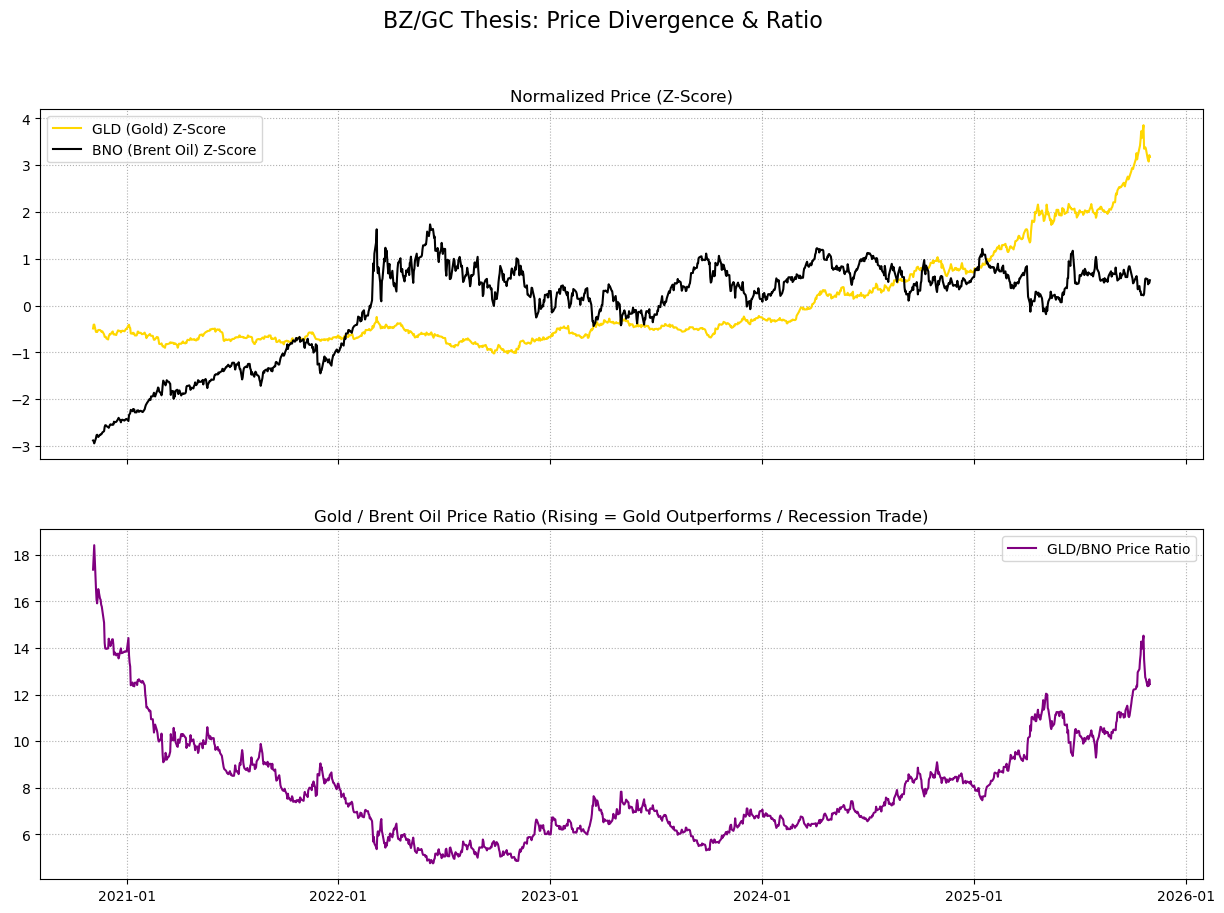

In [9]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of GLD vs. BNO.
# Plot 2: The GLD/BNO Ratio.
#
# This chart shows *what* is happening. When they cross, the ratio
# (Plot 2) changes direction. A rising ratio is the "recession" trade.

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('BZ/GC Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['BNO'], label='BNO (Brent Oil) Z-Score', color='black')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['GLD_BNO_Ratio'], label='GLD/BNO Price Ratio', color='purple')
    ax2.set_title('Gold / Brent Oil Price Ratio (Rising = Gold Outperforms / Recession Trade)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Driver (Growth)...


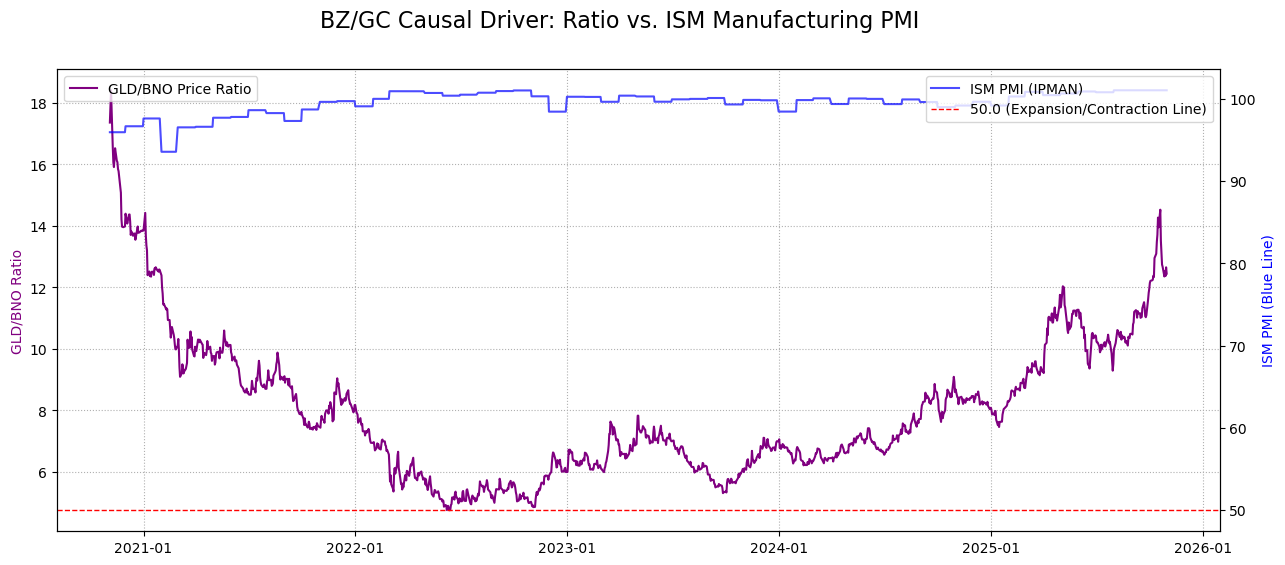

In [13]:
# Cell 10: Visualization - Causal Driver (Global Growth)
#
# Plot the GLD/BNO Ratio vs. the ISM Manufacturing PMI (NPMI).
#
# This chart shows *why* it's happening.
# Thesis: The ratio (purple) should move INVERSELY to the PMI (blue).
# When PMI falls below 50 (contraction), the ratio should rise
# as the "Recession" trade (Long Gold, Short Oil) works.

try:
    print("Plotting Cell 10: Causal Driver (Growth)...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('BZ/GC Causal Driver: Ratio vs. ISM Manufacturing PMI', fontsize=16)

    # Plot 1: GLD/BNO Ratio
    ax1.plot(df.index, df['GLD_BNO_Ratio'], label='GLD/BNO Price Ratio', color='purple')
    ax1.set_ylabel('GLD/BNO Ratio', color='purple')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':')
    
    # Plot 2: ISM PMI (NPMI) on a shared X-axis, different Y-axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['IPMAN'], label='ISM PMI (IPMAN)', color='blue', alpha=0.7)
    ax2.axhline(50, color='red', linestyle='--', linewidth=1, label='50.0 (Expansion/Contraction Line)')
    ax2.set_ylabel('ISM PMI (Blue Line)', color='blue')
    ax2.legend(loc='upper right')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


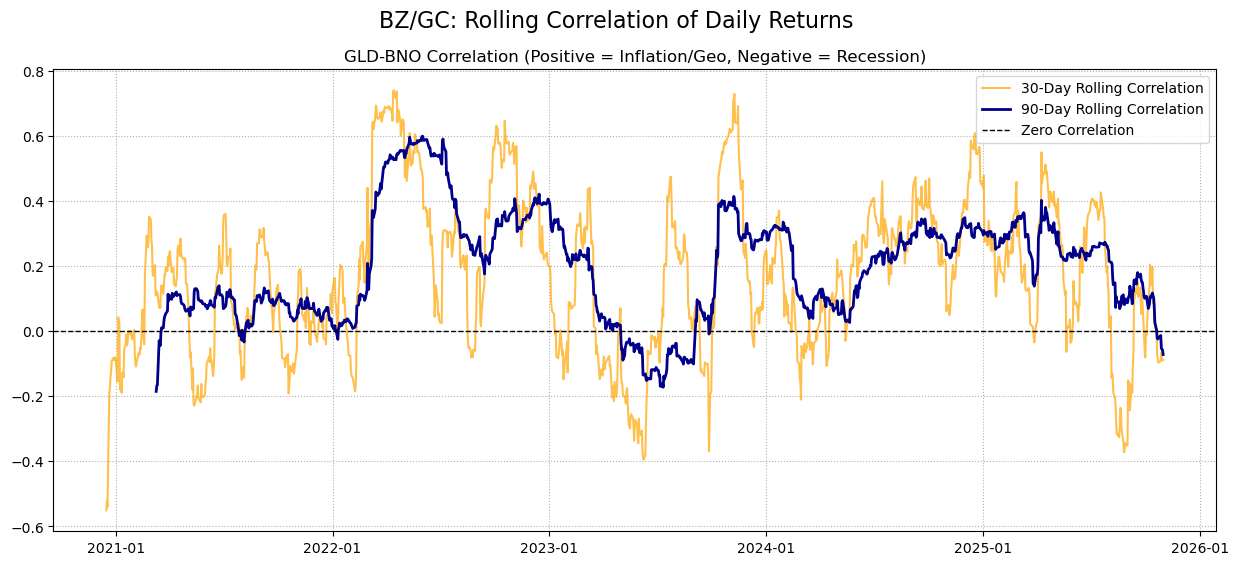

In [14]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the regime.
# * Positive = Inflation/Geopolitics
# * Negative = Recession

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('BZ/GC: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Correlation')
    ax1.set_title('GLD-BNO Correlation (Positive = Inflation/Geo, Negative = Recession)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

In [16]:
# Cell 12: LLM Analysis & Insights
#
# Pass the most recent data to the LLM for a qualitative synthesis.

try:
    print("Sending data to LLM for analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # Create a summary of the latest data points
    data_summary = f"""
    - **Date:** {latest_data.name.strftime('%Y-%m-%d')}
    - **GLD/BNO Price Ratio:** {latest_data['GLD_BNO_Ratio']:.2f}
    - **GLD vs. BNO (Z-Score):** GLD at {df_normalized.iloc[-1]['GLD']:.2f}, BNO at {df_normalized.iloc[-1]['BNO']:.2f}
    - **90-Day Correlation:** {latest_data['Corr_90D']:.3f}
    - **ISM PMI (IPMAN):** {latest_data['IPMAN']:.1f}
    - **Core CPI (CPILFESL, YoY %):** {latest_data['CPILFESL']:.2f}%
    """
    
    # Create the prompt
    prompt = f"""
    **Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.
    
    **Thesis:** I am analyzing the Brent Crude (BNO) vs. Gold (GLD) relationship.
    * **Regime 1 (Positive Correlation):** "Geopolitics / Inflation." A Mideast crisis or high inflation drives *both* prices up.
    * **Regime 2 (Negative Correlation):** "Global Recession." Growth fears crush oil demand (BNO falls) but spark a flight-to-safety in gold (GLD rises). The `GLD_BNO_Ratio` rises sharply.
    
    **Latest OSINT Data:**
    {data_summary}
    
    **Your Task (Provide 3-bullet synthesis):**
    1.  **Regime Check:** Based on the data, which regime are we in? Is the `90-Day Correlation` positive or negative? Is the `NPMI` (growth proxy) above or below the critical 50 level?
    2.  **Causal Driver:** What is the primary driver? (e.g., "This is a clear recession trade," or "This is a stagflation trade" (if CPI is high + PMI is low), or "This is an inflation/geopolitics trade" (if both rise)).
    3.  **Arbitrage/Trade Idea:** Based *only* on this data, what is the clear thematic trade? (e.g., "The data shows a recession signal, favoring Long GLD / Short BNO," or "The data shows a pro-growth/inflationary impulse, favoring Long BNO / Short GLD.")
    """
    
    # Get LLM response
    llm_response = ask_llm(prompt)
    
    print("\n--- 🤖 LLM INTELLIGENCE SYNTHESIS ---")
    print(llm_response)
    print("-------------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analysis failed: {e}")

Sending data to LLM for analysis...



--- 🤖 LLM INTELLIGENCE SYNTHESIS ---
### 1. Regime Check:
- **Correlation:** The `90-Day Correlation` between GLD and BNO is -0.072, which indicates a very weak negative correlation.
- **NPMI (ISM PMI):** The ISM PMI at 101.0 is significantly above the critical 50 level, suggesting strong growth expectations.
- **Regime:** Given the positive NPMI and the weak negative correlation, we are not in a regime of "Global Recession" or "Geopolitics/Inflation." The data does not support either Regime 1 (Positive Correlation) or Regime 2 (Negative Correlation). Instead, it suggests a period of strong economic growth.

### 2. Causal Driver:
- **Primary Driver:** This is a clear pro-growth trade. The high ISM PMI indicates robust industrial activity and economic expansion, which typically suppresses the demand for safe-haven assets like gold while supporting commodity prices such as Brent Crude.

### 3. Arbitrage/Trade Idea:
- **Thematic Trade:** Based on this data, the clear thematic trade is to